# Домашнее задание по курсу анализа данных # 2
Версия от 14.11.2021

Всего 50 баллов = 50 основных + 10 дополнительных

**Оценка**  = (Количество баллов за работу*2 + 20)/10

**Мягкий дедлайн: 06.12.2021  23:59**

**Жесткий дедлайн: 11.12.2021  23:59**

Присылать решение ссылкой на ваш **github** в телеграмм **@Aleron75** или на почту **milenkin.aa@phystech.edu**

**Автор:** Миленькин Александр

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import numpy as np
import pandas as pd
from time import sleep

# Парсим рейтинг преподавателей с Вики-Физтех

<div class="alert alert-info">
    
Итак, перед вами **VIKI-MIPT** - сборник отзывов о кафедрах и преподавателях МФТИ: ` http://wikimipt.org/wiki/ `

Эта кладезь отзывов не раз давала студентам оценить психологический портрет потенциальных экзаменаторов и преподавателей. 
    
    
<img src="../lessons/images/wiki_mipt_front.PNG" height="300" width="1300"> 



# Описание задачи: 

**Задача** - собрать данные по всем текущим преподавателям всех `институтских кафедр` МФТИ.

Собранный датасет должен представлять из себя `.csv` файл со следующими полями:

* `full_name` - ФИО преподавателя
*  `teach_place` - Кафедра
*  `degree`- Ученая Степень
* `knowledge` - Знания
*  `teaching_skill` - Умение преподавать	
* `commication_skill` - В общении	
* `easy_exam` - «Халявность»	
* `overall_score` - Общая оценка

<img src="../lessons/images/wiki_mipt_info.PNG" height="300" width="300"> 

**Комментарий:** - Знание, умение преподавать, в общение, "Халявность" и Общая оценка можно найти странице каждого преподавателя. 

<div class="alert alert-warning">
    
Финальный балл складывается из трех частей:

* Cобранный датасет (выложить архивом на гитхаб)
* python кода, которым был собран датасет (выложить на гитхаб)
* Окуратный и понятный код с комментариями
    
    
**Дополнительные + 10 баллов можно получить за кластеризацию преподавателей, используя только оценки из собранных данных**

# Возможный алгоритм обхода для сбора данных:

In [2]:
# 0 - Открываем с помощью Selenium клавную страницу вики-Физтех- http://wikimipt.org/wiki/   
# 1 - Получаем список кафедр с главной страницу вики-Физтех    
# Обходя список кафедр, "проваливаемся" в каждую страницу кафедру кликом по названию кафедры
#     2 - Получаем список преподавателей
#         Обходя список преподавателей "Проваливаемся" на страницу преподавателя по ФИО преподавателя
#             3 - Получаем табличку данных с характеристмиками преподавателями и прочу необходимую информацию. 
#             Записываем в pandas dataframe
# Сохраняем данные в .csv файл

In [4]:
# Предварительная настройка
driver_path='../data/chromedriver'
service = Service(driver_path)
options = Options()
options.add_argument('--headless')
options.add_argument('--remote-debugging-port=9222')
options.add_argument('--disable-gpu')
browser = webdriver.Chrome(service=service, options=options)
url = "http://wikimipt.org/wiki/"
timeout = 5

In [5]:
def get_department_urls(browser):   
    # Кафедры находятся на сайте в виде первого неупорядоченного списка 
    html_list = browser.find_element(By.TAG_NAME, "ul")
    list_of_departments = html_list.find_elements(By.XPATH, "li/a")
    # Составим список ссылок на кафедры
    list_of_departments_urls = [url.get_attribute("href") for url in list_of_departments]
    list_of_departments_names = [url.get_attribute("title") for url in list_of_departments]
    return (list_of_departments_urls, list_of_departments_names)

In [6]:
# Ссылки имена
def get_name_urls(browser):
    # Кафедра в виде текстовых столбцов 
    list_of_names = browser.find_elements(By.XPATH, '//*[@id="mw-content-text"]/div[3]/ul/li/a')
    if list_of_names != []:
        # Проверка на кафедру системного анализа экономики
        test_href = list_of_names[0].get_attribute("href")
        if test_href.find('#') > 0:
            list_of_names = []
    if list_of_names == []:
        # Кафедра в виде "галлереи"
        html_list = browser.find_element(By.CLASS_NAME, "srf-gallery")
        list_of_names = html_list.find_elements(By.XPATH, 'ul/li/div/div[2]/p/a')
    return ([url.get_attribute("href") for url in list_of_names], [url.get_attribute("title") for url in list_of_names])

In [7]:
# Первая часть информации
def get_person_info(url, name, department):
    # Читаем первую таблицу: выбираем только нужные нам столбцы и транспонируем для удобства
    info_table = pd.read_html(url)[0]
    info_table = info_table[(info_table[0] == 'Дата рождения')  | 
                            (info_table[0] == 'Альма-матер')    | 
                            (info_table[0] == 'Учёная степень') | 
                            (info_table.index == 0)             &
                            (info_table[0].notnull())].transpose()
    # В первой строке по сути находятся названия колонок, заменим численные колонки на строковые
    info_table.columns = info_table.iloc[0]
    info_table = info_table.drop([0], axis=0)
    
    # Смотрим наличие информации и формируем словарь
    row_info = {'full_name':     np.nan,
                'date_of_birth': np.nan,
                'teach_place':   np.nan,
                'degree':        np.nan,
                'department':    department}
    for column in info_table.columns:
        if info_table[column][1].endswith(')'):
            info_table[column][1] = info_table[column][1][:-7]
        if column == 'Дата рождения':
            row_info['date_of_birth'] = info_table[column][1]
        elif column == 'Альма-матер':
            row_info['teach_place'] = info_table[column][1]
        elif column == 'Учёная степень':
            row_info['degree'] = info_table[column][1]
        elif column == 'Работает':
            row_info['department'] = info_table[column][1]
        else:
            row_info['full_name'] = name
    return row_info

In [8]:
# Вторая часть информации
def get_ratings(browser):
    # Все рейтинги помечены именем класса starrating-avg и идут на странице подряд
    ratings = []
    html_ratings = browser.find_elements(By.CLASS_NAME, 'starrating-avg')
    for rating in html_ratings:
        if rating.text.find('нет') < 0:
            number = float(rating.text.split(' ')[0])
        else:
            number = np.nan
        ratings.append(number)
    row_info = {'knowledge': ratings[0],
                'teaching_skill': ratings[1],
                'commication_skill': ratings[2],
                'easy_exam': ratings[3],
                'overall_score': ratings[4]}
    return row_info 

In [9]:
def get_row(browser, url, name, department):
    person_info = get_person_info(url, name, department)
    rating_info = get_ratings(browser)
    person_info.update(rating_info)
    return person_info

In [13]:
browser.get(url)

WebDriverWait(browser, timeout).until(EC.visibility_of_element_located((By.TAG_NAME, 'ul')))
list_of_departments_urls, departments = get_department_urls(browser)

# Тело составление датасета
rows = []
for department_url, department in zip(list_of_departments_urls, departments):
    browser.get(department_url)
    timeout = 20
    try:
        WebDriverWait(browser, timeout).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="mw-content-text"]/div[3]/ul')))
    except TimeoutException:
        continue
    
    list_of_names_urls, names = get_name_urls(browser)
    timeout = 5
    for name_url,name in zip(list_of_names_urls, names):
        browser.get(name_url)
        while True:
            try:
                WebDriverWait(browser, timeout).until(EC.visibility_of_element_located((By.CLASS_NAME, 'starrating-avg')))
                break
            except TimeoutException:
                browser.refresh()
        row = get_row(browser, name_url, name, department)
        rows.append(row)
        
dataset = pd.DataFrame(rows)
dataset.to_csv('../data/mipt_dataset_2.csv', encoding='utf-8-sig', index=False)

In [15]:
browser.close()
dataset

,full_name,date_of_birth,teach_place,degree,department,knowledge,teaching_skill,commication_skill,easy_exam,overall_score
0,Агаханов Назар Хангельдыевич,25 июня 1954,МехМат МГУ,Кандидат физико-математических наук,Кафедра высшей математики,4.86,4.77,4.79,4.25,4.79
1,Агаханова Яна Сергеевна,NaN,NaN,Кандидат физико-математических наук,Кафедра высшей математики,4.51,4.63,4.85,4.81,4.81
2,Алексеев Василий Антонович,NaN,МФТИ,NaN,Кафедра высшей математики,4.67,4.33,4.50,4.17,4.67
3,Амосов Григорий Геннадьевич,27 ноября 1972,ФУПМ МФТИ,Доктор физико-математических наук,Кафедра высшей математики,4.42,3.42,4.33,4.44,4.00
4,Андреев Михаил Юрьевич,NaN,ФПМЭ МФТИ,кандидат физико-математических наук,Кафедра высшей математики,3.46,3.50,3.73,3.47,3.69
...,...,...,...,...,...,...,...,...,...,...
737,Лупандин Иван Владимирович,NaN,NaN,NaN,Кафедра философии,4.67,4.50,4.67,4.50,4.67
738,Петров Алексей Алексеевич,NaN,NaN,NaN,Кафедра философии,NaN,NaN,NaN,NaN,NaN
739,Семёнов Юрий Иванович,5 сентября 1929,Красноярский педагогический институт,Доктор исторических наук,Кафедра философии,NaN,NaN,NaN,NaN,NaN
740,Скворчевский Константин Анатольевич,NaN,МИФИ,Доктор технических наук,Кафедра философии,4.43,4.43,4.29,3.50,4.33


In [134]:
from sklearn.preprocessing import RobustScaler 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme();

dataset = pd.read_csv('../data/mipt_dataset.csv')

In [135]:
for col in dataset.columns:
    print(f"{col}: {dataset[col].isna().sum()}")

full_name: 0
date_of_birth: 552
teach_place: 401
degree: 456
department: 0
knowledge: 141
teaching_skill: 141
commication_skill: 139
easy_exam: 138
overall_score: 138


In [136]:
dataset = dataset.drop(['full_name','date_of_birth','teach_place','degree','department'], axis=1)

In [137]:
fill_dataset = dataset.copy(deep=True)
drop_dataset = dataset.copy(deep=True)

In [138]:
col_names = ['knowledge', 'teaching_skill', 'commication_skill', 'easy_exam', 'overall_score']
for col in col_names:
    fill_dataset[col] = fill_dataset[col].fillna(fill_dataset[col].mean())
drop_dataset = drop_dataset.dropna()

In [139]:
features_d = drop_dataset[col_names]
featuref_f = fill_dataset[col_names]

scaler = RobustScaler()
features_d = scaler.fit_transform(features_d.values)
featuref_f = scaler.fit_transform(featuref_f.values)

drop_dataset[col_names] = features_d
fill_dataset[col_names] = featuref_f

In [143]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouettes = []
range_n_clusters = range(2,14)
print("=====DROP_DATASET=====")
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
    cluster_labels = clusterer.fit_predict(drop_dataset)
    silhouette_avg = silhouette_score(drop_dataset, cluster_labels)
    silhouettes += silhouette_avg
    print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_avg)

silhouettes = []
print("=====FILL_DATASET=====")
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
    cluster_labels = clusterer.fit_predict(fill_dataset)
    silhouette_avg = silhouette_score(fill_dataset, cluster_labels)
    silhouettes += silhouette_avg
    print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_avg)

=====DROP_DATASET=====
For n_clusters = 2 the average silhouette_score is : 0.525511277019145
For n_clusters = 3 the average silhouette_score is : 0.4066776932563452
For n_clusters = 4 the average silhouette_score is : 0.2933410049427186
For n_clusters = 5 the average silhouette_score is : 0.3047656852803089
For n_clusters = 6 the average silhouette_score is : 0.2876377452722378
For n_clusters = 7 the average silhouette_score is : 0.28989528220364374
For n_clusters = 8 the average silhouette_score is : 0.26925828230863547
For n_clusters = 9 the average silhouette_score is : 0.2625554371249949
For n_clusters = 10 the average silhouette_score is : 0.2651191169086831
For n_clusters = 11 the average silhouette_score is : 0.2611875561667937
For n_clusters = 12 the average silhouette_score is : 0.2468176936883841
For n_clusters = 13 the average silhouette_score is : 0.25870320227489446
=====DROP_DATASET=====
For n_clusters = 2 the average silhouette_score is : 0.5590946782530386
For n_cluste

In [149]:
from sklearn.decomposition import PCA

data_x_y_drop = PCA(n_components=2, random_state=22).fit_transform(drop_dataset)
data_x_y_fill = PCA(n_components=2, random_state=22).fit_transform(fill_dataset)

In [151]:
clusterer = KMeans(n_clusters=5, random_state=42, max_iter=500)
cluster_labels_drop = clusterer.fit_predict(drop_dataset)
clusterer = KMeans(n_clusters=7, random_state=42, max_iter=500)
cluster_labels_fill = clusterer.fit_predict(fill_dataset)

In [153]:
data_x_drop = data_x_y_drop.transpose()[0]
data_y_drop = data_x_y_drop.transpose()[1]
data_x_fill = data_x_y_fill.transpose()[0]
data_y_fill = data_x_y_fill.transpose()[1]

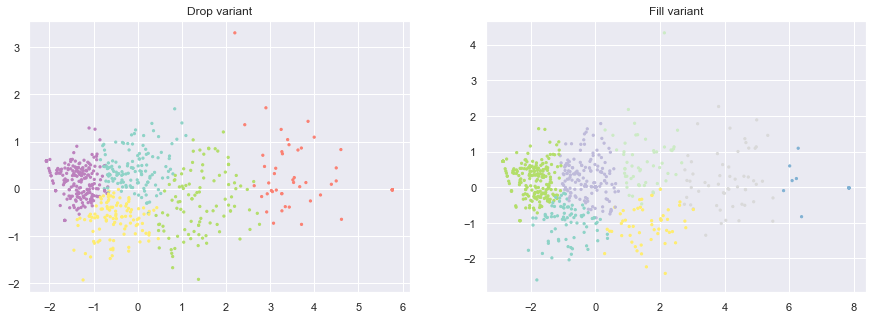

In [166]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))


axis[0].scatter(data_x_drop, data_y_drop, c=cluster_labels_drop, cmap ='Set3', s=5)
axis[0].set_title("Drop variant")
  
axis[1].scatter(data_x_fill, data_y_fill, c=cluster_labels_fill, cmap ='Set3', s=5)
axis[1].set_title("Fill variant")

plt.show()

# Вспомогательные элементы для майнинга данных

* Библиотека `Selenium`: https://selenium-python.readthedocs.io/

Полезные методы и рекомендации:
    
* `element = browser.find_elements_by_*что угодно*()` # Поиск элемента на странице
* `element.click()` # Кликнуть по элементу (провалится по ссылке / расскрыть банер)
* `browser.back()` # Вернуться назад 
* `pd.read_html()` # Способ загрузить таблицку из html сразу в Pandas
* Спрашивать в чате или гуглить

# Примечания

In [14]:
# Таблица с рейтингом парсится неправильно, её нужно прасить отдельно
info_table = pd.read_html('http://wikimipt.org/wiki/%D0%90%D0%B3%D0%B0%D1%85%D0%B0%D0%BD%D0%BE%D0%B2_%D0%9D%D0%B0%D0%B7%D0%B0%D1%80_%D0%A5%D0%B0%D0%BD%D0%B3%D0%B5%D0%BB%D1%8C%D0%B4%D1%8B%D0%B5%D0%B2%D0%B8%D1%87')[1]
info_table

,0,1
0,Знания,NaN
1,Умение преподавать,NaN
2,В общении,NaN
3,«Халявность»,NaN
4,Общая оценка,NaN
